# Hamiltonian MCMC demo

Hamiltonian Monte-Carlo (HMC) is a MCMC algorithm which is able to efficiently sample from complex PDFs which present difficulty for other algorithms, such as those which strong non-linear correlations.
However, HMC requires not only the log-posterior probability but also its gradient with respect to the model parameters.
In cases where this gradient can be calculated efficiently HMC can be very effective.

In [1]:
import matplotlib.pyplot as plt
from numpy import sqrt, exp, array
from inference.mcmc import HamiltonianChain

Define a 3D torus-shaped posterior distribution as our test-case, with a `gradient()` method to calculate the gradient of the log-probability analytically. This posterior has strong non-linear correlation which can cause issues for some MCMC algorithms, but is handled well by HMC.

In [2]:
class ToroidalGaussian(object):
    def __init__(self):
        self.R0 = 1. # torus major radius
        self.ar = 10. # torus aspect ratio
        self.w2 = (self.R0/self.ar)**2

    def __call__(self, theta):
        x, y, z = theta
        r = sqrt(z**2 + (sqrt(x**2 + y**2) - self.R0)**2)
        return -0.5*r**2 / self.w2

    def gradient(self, theta):
        x, y, z = theta
        R = sqrt(x**2 + y**2)
        K = 1 - self.R0/R
        g = array([K*x, K*y, z])
        return -g/self.w2

In [3]:
# create an instance of our posterior class
posterior = ToroidalGaussian()

# create the chain object
chain = HamiltonianChain(posterior = posterior, grad = posterior.gradient, start = [1,0.1,0.1])

# advance the chain to generate the sample
chain.advance(6000)

  advancing chain:   [ complete ]                         


In [10]:
# choose how many samples will be thrown away from the start of the chain as 'burn-in'
chain.burn = 1000

In [11]:
# extract sample and probability data from the chain
probs = chain.get_probabilities()
colors = exp(probs - max(probs))
xs, ys, zs = [ chain.get_parameter(i) for i in [0,1,2] ]

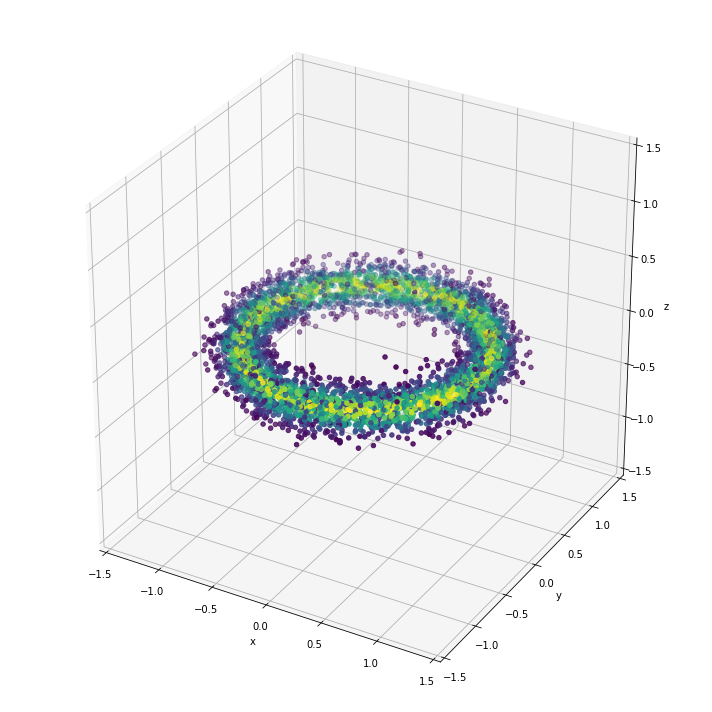

In [12]:
# Plot the sample we've generated as a 3D scatterplot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
L = 1.5
ax.set_xlim([-L,L]); ax.set_ylim([-L,L]); ax.set_zlim([-L,L])
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.scatter(xs, ys, zs, c=colors)

plt.tight_layout()
plt.show()

We can plot all the possible 1D and 2D marginal distirbutions of the posterior (or a sub-set of them) using the ``matrix_plot()`` method:

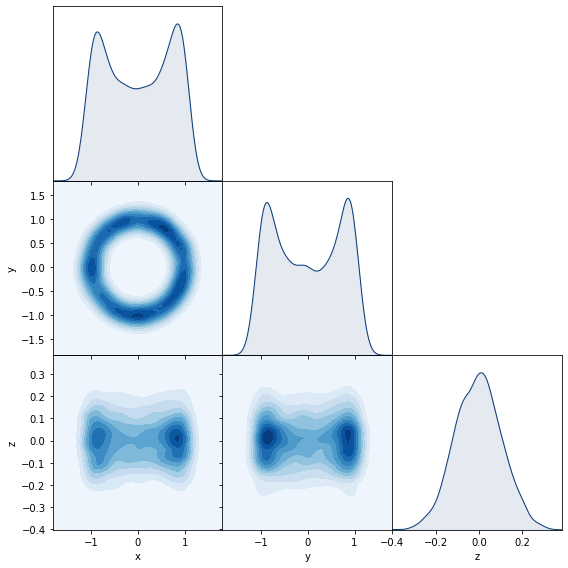

In [14]:
chain.matrix_plot(labels = ['x','y','z'])